This notebook is aimed at generating code for covid19 regression with the mobilint data there

Author Zaid Bin Tariq
Date: 5/19/2020

In [1]:
# Section 1 - Loading our Libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
import numpy as np
from sklearn.model_selection import train_test_split
import os

# %matplotlib inline #if you're working in a Jupyter notebook


In [2]:

# print(commulative_cases.shape)

def newcases(St_name,df,k=100,dayZero= True):
    if (dayZero):
        com_cases_timeseries,dte = getDayZeroSeries(df,St_name,k)
    else:
        com_cases_timeseries = df[df['state']==St_name]['cases'].values
        dte = df[(df['state']==St_name)& (df['cases']>k)]['date'].values[0]
    new_daily_cases = np.zeros((com_cases_timeseries.shape[0]))
    new_daily_cases[0] = com_cases_timeseries[0]
    for i in range(1,com_cases_timeseries.shape[0]):
        new_daily_cases[i] = com_cases_timeseries[i]-com_cases_timeseries[i-1]
    return new_daily_cases,dte
def get_series_perThousand(in_series,df,St_name):
    newcases_perthousand = (in_series)*(100000/df[df['State']==St_name]['Population'].values)
    return newcases_perthousand

def getDayZeroSeries(df,St_name,k=100):
    dte = df[(df['state']==St_name)& (df['cases']>k)]['date'].values[0]
#     print(dte)
    return df[(df['state']==St_name)& (df['cases']>k)]['cases'].values,dte

def plt_series(Series,Ylabel):
    x = np.arange(0,len(Series))
    plt.plot(x,Series)
    plt.xlabel("Number of Days")
    plt.ylabel(Ylabel)
    
def plt_state(St_name,k,perThousand):
    new_cases,dte = newcases(St_name,df_states,K,True)
    new_cases_perthousand = get_series_perThousand(new_cases,df_US_population_state,St_name)
    if perThousand:
        plt_series(new_cases_perthousand,"New Cases per Thousand")
    else:
        plt_series(new_cases,"New Cases") 
    return dte

def getXY(St_name,k,perThousand):
    new_cases,dte = newcases(St_name,df_states,K,True)
    new_cases_perthousand = get_series_perThousand(new_cases,df_US_population_state,St_name)
    x = np.arange(0,len(new_cases))
    if perThousand:
#         plt_series(new_cases_perthousand,"New Cases per Thousand")
        return dte,new_cases_perthousand,x
    else:
#         plt_series(new_cases,"New Cases") 
        return dte,new_cases,x

def moving_average(fltr_size,series):
    return np.convolve(series,np.ones((fltr_size,))/filter_size,mode = 'valid')

In [3]:
# load US_population data
file_path = '../Data/'
filename_population = 'US_population.csv'
df_US_population_state = pd.read_csv(file_path+filename_population,thousands = ',')
df_US_population_state.head()

###
# read the data file containing per state daily new cases data
file_path = '../Data/covid-19-data-master/covid-19-data-master/'
filename = 'us-states.csv'
df_states = pd.read_csv(file_path+filename)
df_states['date'] = pd.to_datetime(df_states['date'])
df_states.head()

###
filename = 'Global_Mobility_Report.csv'
file_path = '../Data/'
df_loc = pd.read_csv(file_path+filename)
df_loc['date'] = pd.to_datetime(df_loc['date'])

D:\Anaconda\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Pick Test States from the data 
#Pick a State and generate training and test data for that state
# Training data will include 5 days
# Can increment the days 

In [148]:
# Lets select the states for training and testing
Number_Training_states = 35
K = 50 # Represents the minimum number of cases at day zero
Country= 'United States'
Mobility_data_lag = 10
prediction_horizon = 7
##
c= np.unique(df_states['state'])
States = list()
for name in c:
    if (name in np.unique(df_US_population_state['State'].values)):
        States.append(name)
# States_index = np.random.choice(list(np.arange(0,len(States))),size = Number_Training_states,replace = False)


Testing_States = ['Idaho', 'Kansas', 'Massachusetts', 'New Mexico', 
                  'Michigan', 'Ohio', 'Pennsylvania', 'Rhode Island', 'South Dakota',
                  'Vermont', 'Virginia', 'Washington', 'Wisconsin']


Training_States= list()
for name in States:
    if(name not in Testing_States):
        Training_States.append(name)

In [91]:
def getStateData(State_name):
#     State_name = States[States_index[i]]
    count=-1
    print(State_name)
    Start_dte,cases_comp,x_cases = getXY(State_name,K,True)
    df_US =  df_loc[(df_loc["country_region"]== Country) & (df_loc["sub_region_2"].isna()==True) &(df_loc["sub_region_1"]==State_name)]
    d = Start_dte - np.timedelta64(Mobility_data_lag,'D')
    mobility_data= df_US[df_US['date']>d][df_US.columns[5:]].values
    
    
    input_x = np.zeros((Mobility_data_lag,mobility_data.shape[1]+1))
    output_y = np.zeros((prediction_horizon,1))
    vect = np.zeros((mobility_data.shape[1]+1))

    for start in range(cases_comp.shape[0]-prediction_horizon):
        if(start+Mobility_data_lag+prediction_horizon > cases_comp.shape[0]):
            break
        if(count==-1):
            count = count+1
        elif(count==0):
#             print(start)
            count=count+1
            output_y[:,0] = cases_comp[start+Mobility_data_lag-1:start+Mobility_data_lag+prediction_horizon-1]
    #         print(output_y)
            tensor_X = np.copy(input_x[np.newaxis,:,:])
            tensor_Y = np.copy(output_y[np.newaxis,:,:])
    #         print(tensor_Y)
        elif(count>=1):
    #         print(start,'a')
    #         print(tensor_Y)
            output_y[:,0] = cases_comp[start+Mobility_data_lag-1:start+Mobility_data_lag+prediction_horizon-1]
    #         print(output_y)
    #         print(tensor_Y)

            tensor_X = np.append(tensor_X,input_x[np.newaxis,:,:],axis=0)
            tensor_Y = np.append(tensor_Y,output_y[np.newaxis,:,:],axis=0)

        for pointer in range(0,Mobility_data_lag):

            vect[0] = cases_comp[start+pointer]
            vect[1:] = mobility_data[start+pointer,:]
            input_x[pointer,:] = vect
    return tensor_X,tensor_Y

In [303]:
input_x[:,0]

array([14.70907116, 13.75405979, 14.52039814, 13.81084251, 13.82125664,
       12.74789143, 12.8146925 , 10.63417721,  9.98835373, 10.79132938])

Michigan


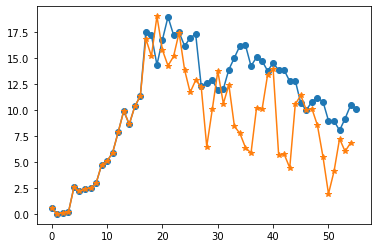

In [305]:
p,cases_comp = get_predictionBased(State_name,-50,10)
plt.plot(p,marker='o')
plt.plot(cases_comp,marker='*')
plt.show()

In [92]:
# chose the state
count = -1


for nm in Training_States:
    State_name = nm
    print(State_name)
    Start_dte,cases_comp,x_cases = getXY(State_name,K,True)
    df_US =  df_loc[(df_loc["country_region"]== Country) & (df_loc["sub_region_2"].isna()==True) &(df_loc["sub_region_1"]==State_name)]
    d = Start_dte - np.timedelta64(Mobility_data_lag,'D')
    mobility_data= df_US[df_US['date']>d][df_US.columns[5:]].values
    
    
    input_x = np.zeros((Mobility_data_lag,mobility_data.shape[1]+1))
    output_y = np.zeros((prediction_horizon,1))
    vect = np.zeros((mobility_data.shape[1]+1))

    for start in range(cases_comp.shape[0]-prediction_horizon):
        if(start+Mobility_data_lag+prediction_horizon > cases_comp.shape[0]):
            break
        if(count==-1):
            count = count+1
        elif(count==0):
#             print(start)
            count=count+1
            output_y[:,0] = cases_comp[start+Mobility_data_lag-1:start+Mobility_data_lag+prediction_horizon-1]
    #         print(output_y)
            tensor_X = np.copy(input_x[np.newaxis,:,:])
            tensor_Y = np.copy(output_y[np.newaxis,:,:])
    #         print(tensor_Y)
        elif(count>=1):
    #         print(start,'a')
    #         print(tensor_Y)
            output_y[:,0] = cases_comp[start+Mobility_data_lag-1:start+Mobility_data_lag+prediction_horizon-1]
    #         print(output_y)
    #         print(tensor_Y)

            tensor_X = np.append(tensor_X,input_x[np.newaxis,:,:],axis=0)
            tensor_Y = np.append(tensor_Y,output_y[np.newaxis,:,:],axis=0)

        for pointer in range(0,Mobility_data_lag):

            vect[0] = cases_comp[start+pointer]
            vect[1:] = mobility_data[start+pointer,:]
            input_x[pointer,:] = vect
import random
shuffle_array = np.arange(0,tensor_X.shape[0])
random.shuffle(shuffle_array)
tensor_X = tensor_X[shuffle_array,:,:]
tensor_Y = tensor_Y[shuffle_array,:,:]

Alabama
Alaska
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
Florida
Georgia
Hawaii
Illinois
Indiana
Iowa
Kentucky
Louisiana
Maine
Maryland
Minnesota
Mississippi
Missouri
Montana
Nebraska
Nevada
New Hampshire
New Jersey
New York
North Carolina
North Dakota
Oklahoma
Oregon
South Carolina
Tennessee
Texas
Utah
West Virginia
Wyoming


In [93]:
# tensor_X = np.reshape(tensor_X,(tensor_X.shape[0],tensor_X.shape[2],tensor_X.shape[1]))

In [94]:
tensor_Y = np.reshape(tensor_Y,(tensor_Y.shape[0],tensor_Y.shape[1]))

In [95]:
X_train, X_test, y_train, y_test= train_test_split(tensor_X,tensor_Y,test_size = 0.2,random_state=1)

In [96]:
print(X_train.shape,y_train.shape)

(976, 10, 7) (976, 10)


In [97]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout
from keras.layers import Bidirectional
from keras.layers import Flatten

In [98]:
model = Sequential()
model.add(Bidirectional(LSTM(60,return_sequences = True), input_shape=tensor_X.shape[1:]))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(40,return_sequences = True), input_shape=tensor_X.shape[1:]))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dropout(0.2))
model.add(Dense(20))
model.add(Dropout(0.2))


model.add(Dense(1))

# model.add(Dense(5))
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()
#_100_02_20_02

from keras.callbacks import ModelCheckpoint
modelPath = './models'
checkpointer = ModelCheckpoint(filepath=os.path.join(modelPath,'bidirections_horizon_10_BdbdDdDd_60_02_40_02_50_02_20_02b.wgt'), 
                                verbose=1, 
                                save_best_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_43 (Bidirectio (None, 10, 120)           32640     
_________________________________________________________________
dropout_79 (Dropout)         (None, 10, 120)           0         
_________________________________________________________________
bidirectional_44 (Bidirectio (None, 10, 80)            51520     
_________________________________________________________________
flatten_20 (Flatten)         (None, 800)               0         
_________________________________________________________________
dropout_80 (Dropout)         (None, 800)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 50)                40050     
_________________________________________________________________
dropout_81 (Dropout)         (None, 50)                0         
__________

In [99]:

model.fit(X_train, y_train[:,prediction_horizon-1], epochs=30, batch_size=32, verbose=1,callbacks = [checkpointer],validation_data =(X_test,y_test[:,prediction_horizon-1]) )
# tensor_X.shape

Train on 976 samples, validate on 244 samples
Epoch 1/30
976/976 [==============================] - 9s 9ms/step - loss: 89.0837 - val_loss: 52.7828

Epoch 00001: val_loss improved from inf to 52.78280, saving model to ./models\bidirections_horizon_10_BdbdDdDd_60_02_40_02_50_02_20_02b.wgt
Epoch 2/30
976/976 [==============================] - 2s 2ms/step - loss: 44.3071 - val_loss: 34.2799

Epoch 00002: val_loss improved from 52.78280 to 34.27986, saving model to ./models\bidirections_horizon_10_BdbdDdDd_60_02_40_02_50_02_20_02b.wgt
Epoch 3/30
976/976 [==============================] - 2s 2ms/step - loss: 34.7090 - val_loss: 31.4979

Epoch 00003: val_loss improved from 34.27986 to 31.49793, saving model to ./models\bidirections_horizon_10_BdbdDdDd_60_02_40_02_50_02_20_02b.wgt
Epoch 4/30
976/976 [==============================] - 2s 2ms/step - loss: 27.4765 - val_loss: 32.7836

Epoch 00004: val_loss did not improve from 31.49793
Epoch 5/30
976/976 [==============================] - 2s 2ms

In [149]:
model.load_weights(os.path.join(modelPath,'bidirections_horizon_7_BdbdDdDd_60_02_40_02_50_02_20_02.wgt'))

In [150]:
i=27
model.predict(T_X[i:i+1,:,:])

array([[5.07882]], dtype=float32)

In [151]:
T_Y[i:i+1,0]

array([[3.63988939]])

In [152]:
T_X[i:i+1,:,0]

array([[1.52980858, 2.23316885, 2.91894511, 2.70793703, 2.98928114,
        2.70793703, 2.58484899, 2.69035303, 2.12766481, 3.95640151]])

Idaho


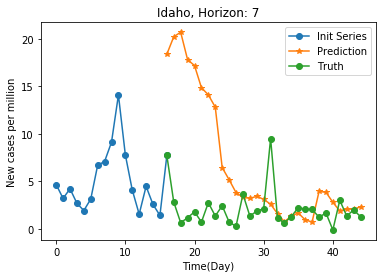

Kansas


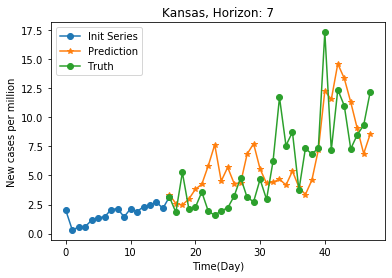

Massachusetts


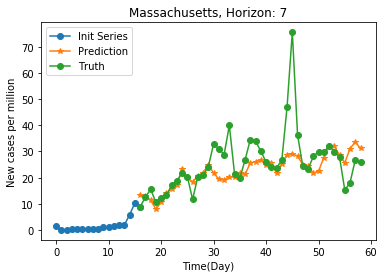

New Mexico


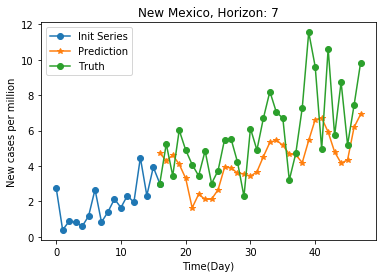

Michigan


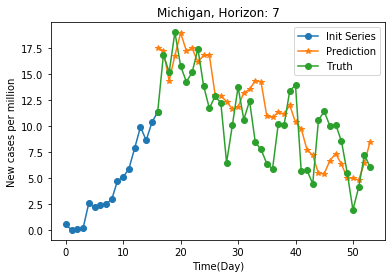

Ohio


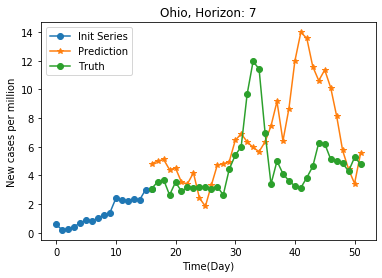

Pennsylvania


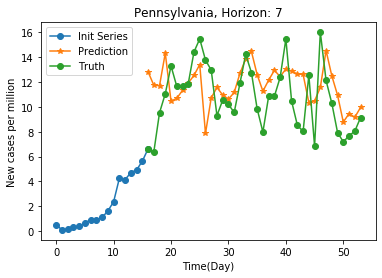

Rhode Island


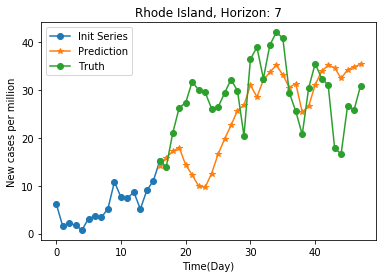

South Dakota


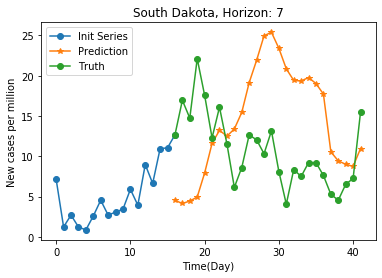

Vermont


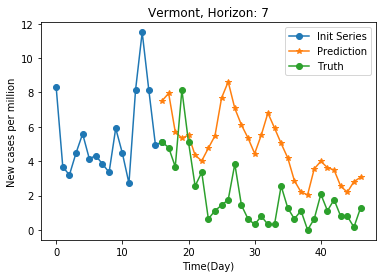

Virginia


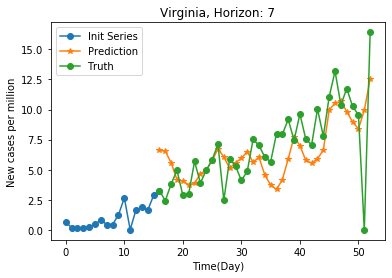

Washington


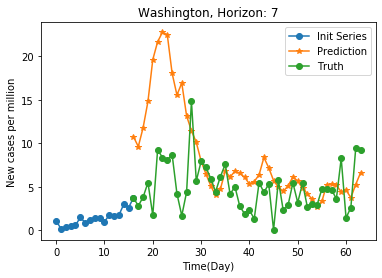

Wisconsin


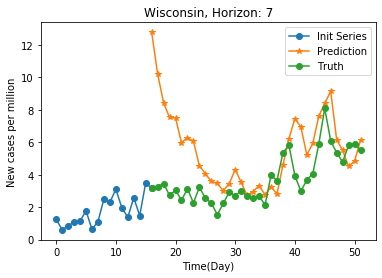

In [153]:
for i in range(len(Testing_States)):
#     i = 9
    State_name = Testing_States[i]
    T_X,T_Y = getStateData(State_name)
    prediction = model.predict(T_X[:,:,:])
    Start_dte,cases_comp,x_cases = getXY(State_name,K,True)
    plt.figure()
    plt.plot(cases_comp[0:Mobility_data_lag+prediction_horizon],marker = "o")
    plt.plot(np.arange(prediction_horizon+Mobility_data_lag-1,-1+prediction_horizon+Mobility_data_lag+T_Y.shape[0]),prediction,marker = '*')
    plt.plot(np.arange(prediction_horizon+Mobility_data_lag-1,-1+prediction_horizon+Mobility_data_lag+T_Y.shape[0]),T_Y[:,prediction_horizon-1],marker = 'o')
    
    plt.title(State_name+ ", Horizon: "+str(prediction_horizon))
    plt.xlabel("Time(Day)")
    plt.ylabel("New cases per million")
    plt.legend(["Init Series","Prediction","Truth"])
    plt.show()
#     break
    

In [155]:
# Changing the location Data
print(T_X.shape)
T_X[:,:,1:].shape 
# np.random.randint(3,(3,3))

(36, 10, 7)


(36, 10, 6)

Idaho


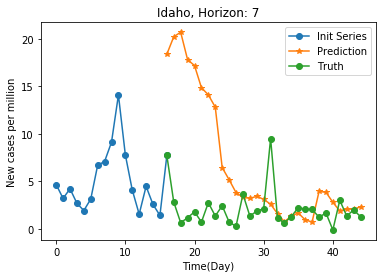

Kansas


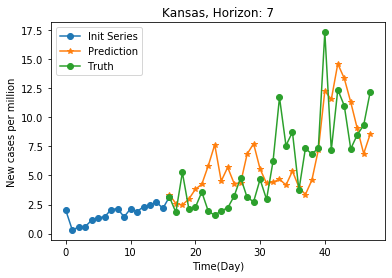

Massachusetts


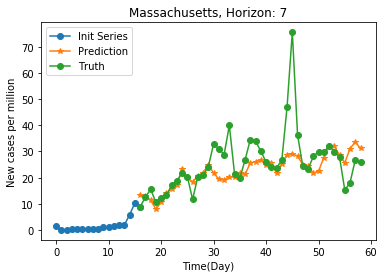

New Mexico


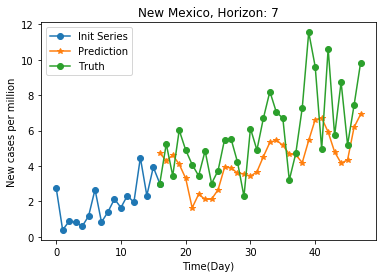

Michigan


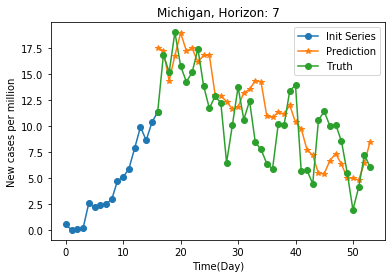

Ohio


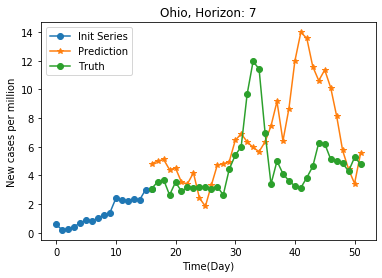

Pennsylvania


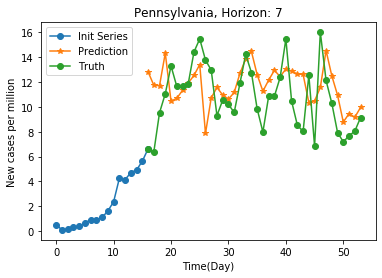

Rhode Island


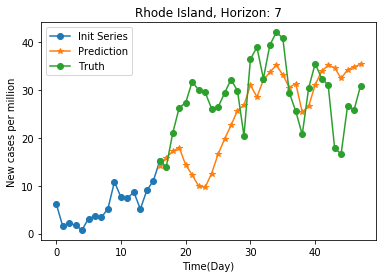

South Dakota


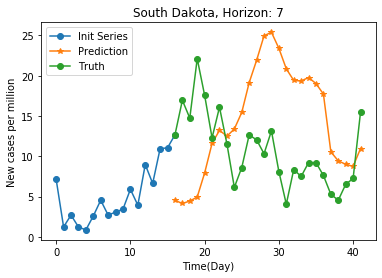

Vermont


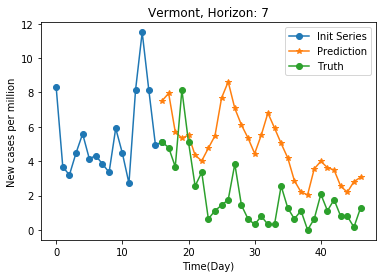

Virginia


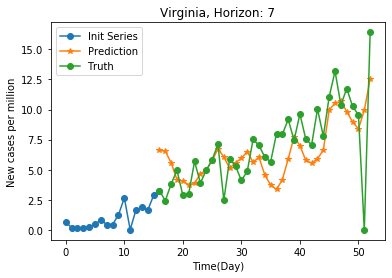

Washington


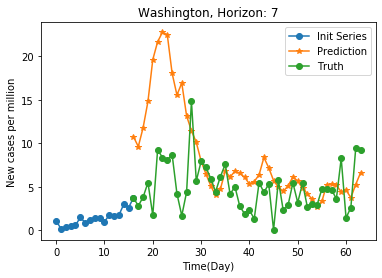

Wisconsin


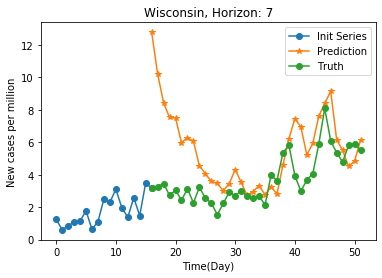

In [175]:
for i in range(len(Testing_States)):
#     i = 9
    State_name = Testing_States[i]
    T_X,T_Y = getStateData(State_name)
#     T_X[:,:,1:] = 10
    prediction = model.predict(T_X[:,:,:])
    Start_dte,cases_comp,x_cases = getXY(State_name,K,True)
    plt.figure()
    plt.plot(cases_comp[0:Mobility_data_lag+prediction_horizon],marker = "o")
    plt.plot(np.arange(prediction_horizon+Mobility_data_lag-1,-1+prediction_horizon+Mobility_data_lag+T_Y.shape[0]),prediction,marker = '*')
    plt.plot(np.arange(prediction_horizon+Mobility_data_lag-1,-1+prediction_horizon+Mobility_data_lag+T_Y.shape[0]),T_Y[:,prediction_horizon-1],marker = 'o')
    
    plt.title(State_name+ ", Horizon: "+str(prediction_horizon))
    plt.xlabel("Time(Day)")
    plt.ylabel("New cases per million")
    plt.legend(["Init Series","Prediction","Truth"])
    plt.show()
    

In [334]:
def get_predictionBased(State_name,mobility_level,rng):
    count=-1
    print(State_name)
    Start_dte,cases_comp,x_cases = getXY(State_name,K,True)
    df_US =  df_loc[(df_loc["country_region"]== Country) & (df_loc["sub_region_2"].isna()==True) &(df_loc["sub_region_1"]==State_name)]
    d = Start_dte - np.timedelta64(Mobility_data_lag,'D')
    mobility_data= df_US[df_US['date']>d][df_US.columns[5:]].values


    input_x = np.zeros((Mobility_data_lag,mobility_data.shape[1]+1))
    output_y = np.zeros((prediction_horizon,1))
    vect = np.zeros((mobility_data.shape[1]+1))
    prediction_list = list()
    prediction_list = cases_comp[0:Mobility_data_lag+prediction_horizon]

    for start in range(cases_comp.shape[0]-prediction_horizon):
        if(start+Mobility_data_lag+prediction_horizon > cases_comp.shape[0]):
                break
        for pointer in range(0,Mobility_data_lag):
            vect[0] = prediction_list[start+pointer]
            vect[1:] = mobility_data[start+pointer,:]
            input_x[pointer,:] = vect
            
            if(start<rng):
                input_x[pointer,1:] = mobility_level
        prediction = model.predict(input_x[np.newaxis,:,:])
        prediction_list= np.append(prediction_list,prediction[0][0])
    return prediction_list,cases_comp
    #     break 

Idaho
46 (46,)
Idaho


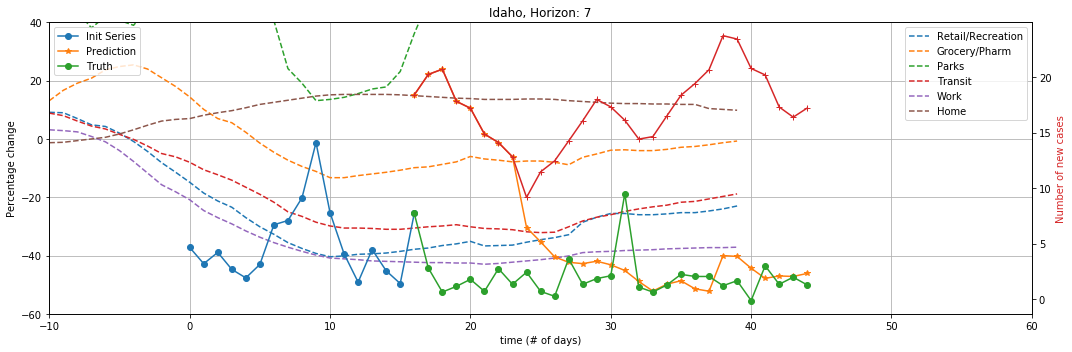

Kansas
49 (49,)
Kansas


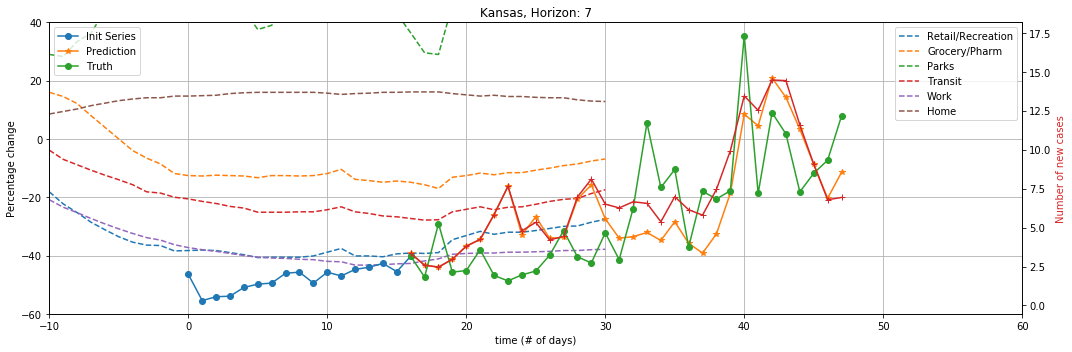

Massachusetts
60 (60,)
Massachusetts


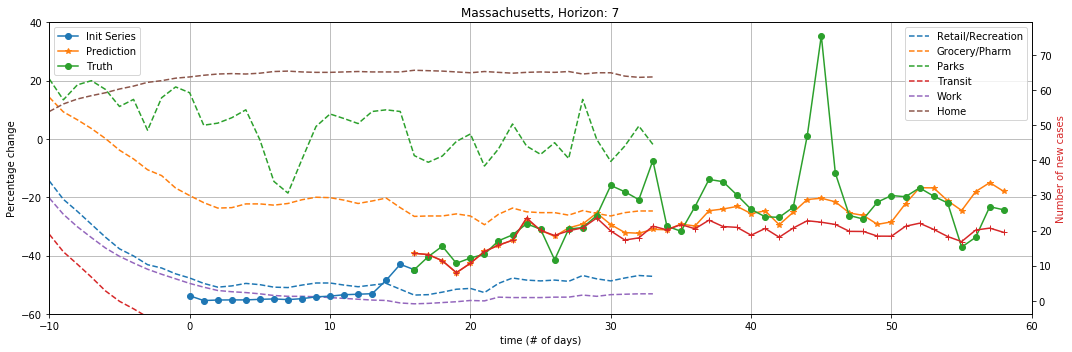

New Mexico
49 (49,)
New Mexico


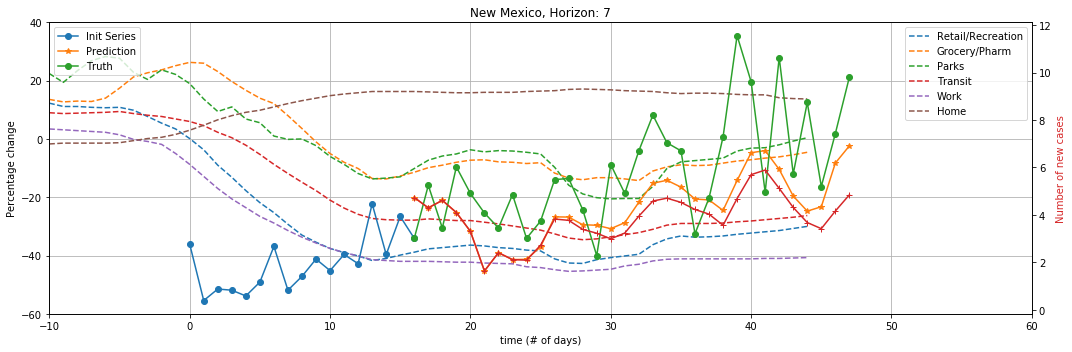

Michigan
55 (55,)
Michigan


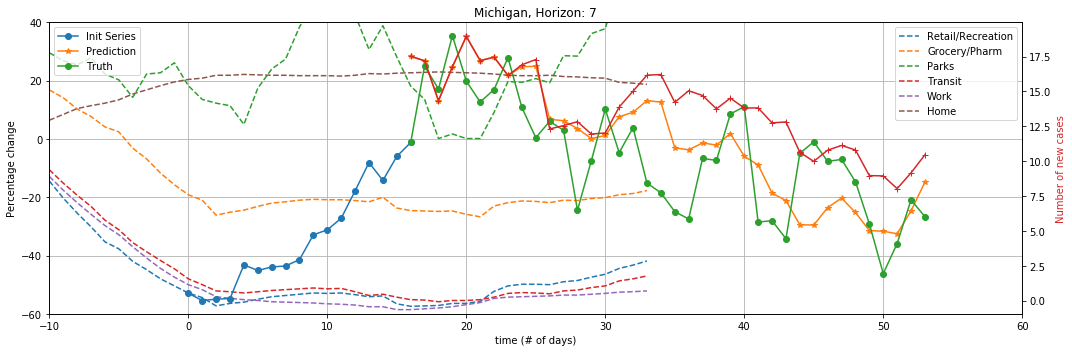

Ohio
53 (53,)
Ohio


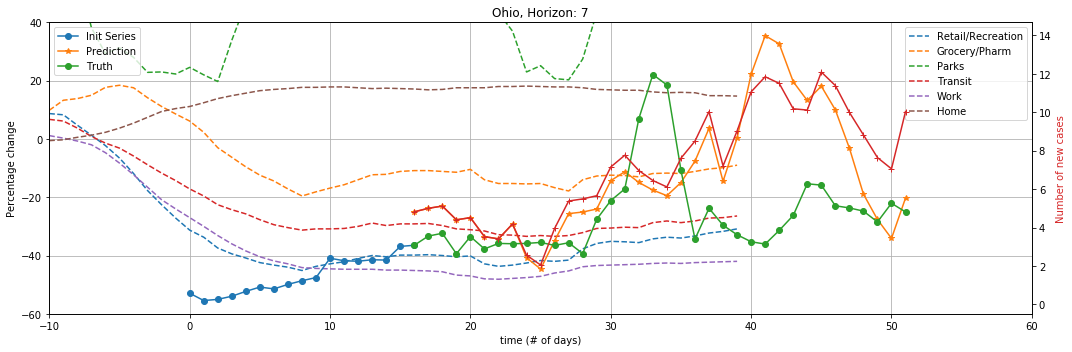

Pennsylvania
55 (55,)
Pennsylvania


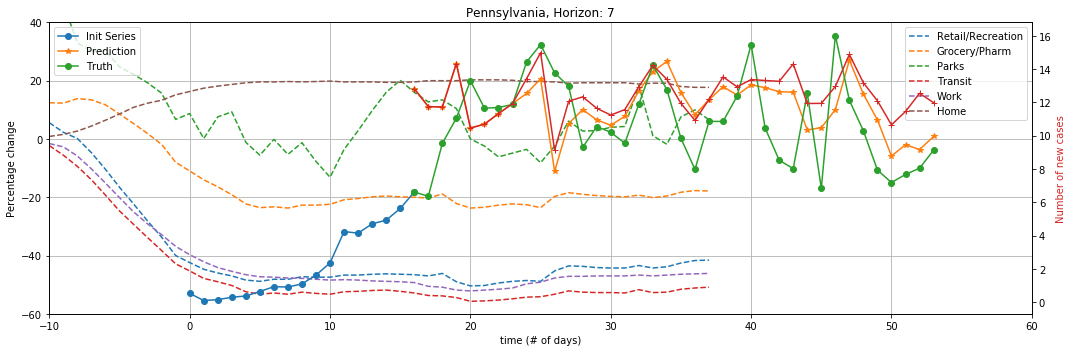

Rhode Island
49 (49,)
Rhode Island


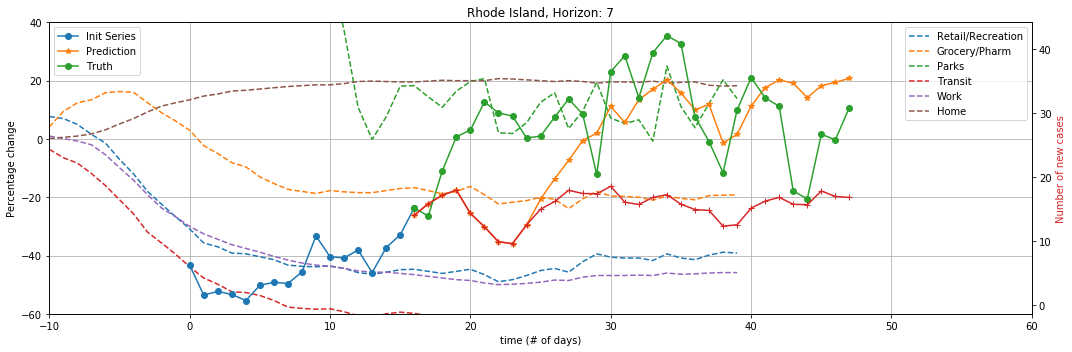

South Dakota
43 (43,)
South Dakota


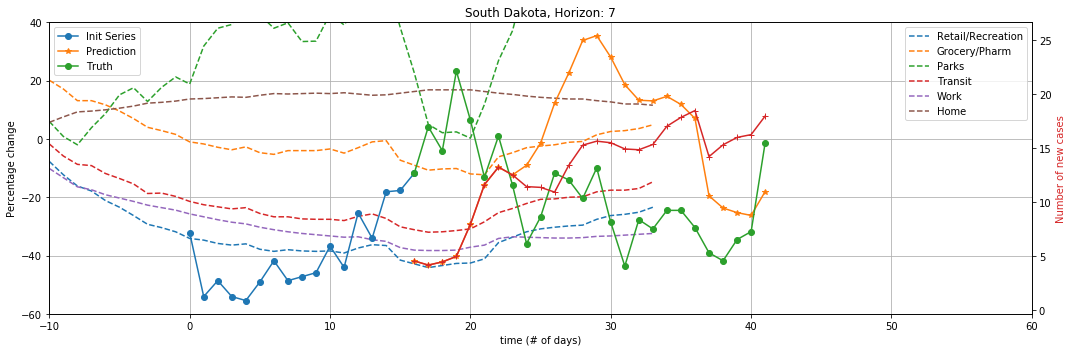

Vermont
48 (48,)
Vermont


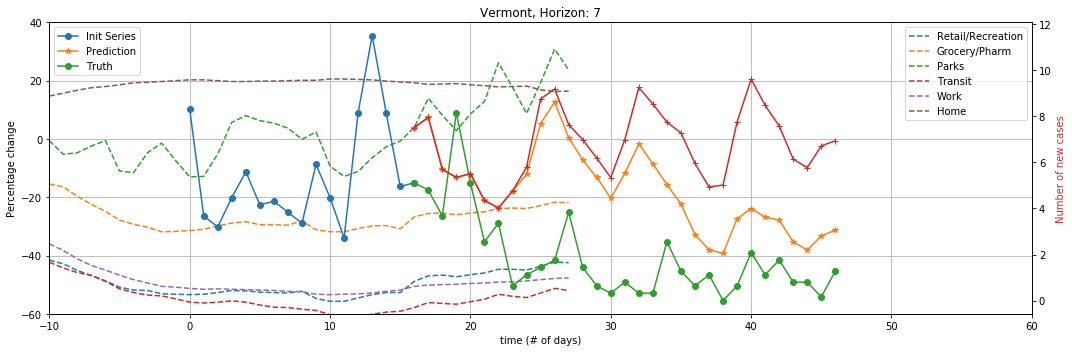

Virginia
54 (54,)
Virginia


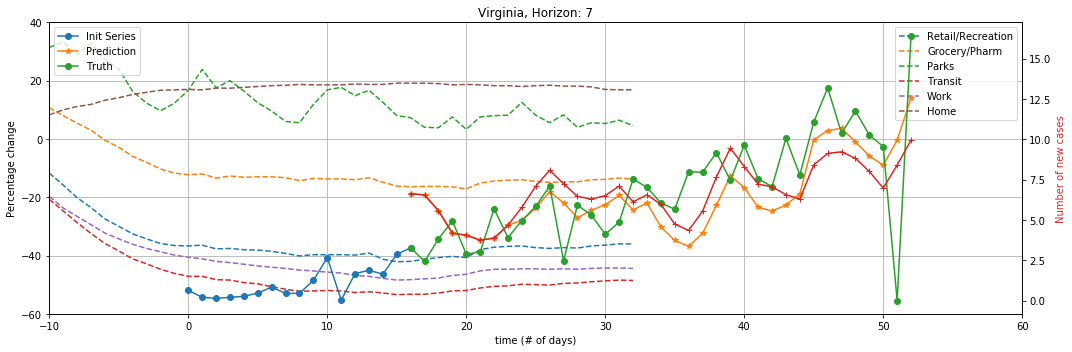

Washington
65 (65,)
Washington


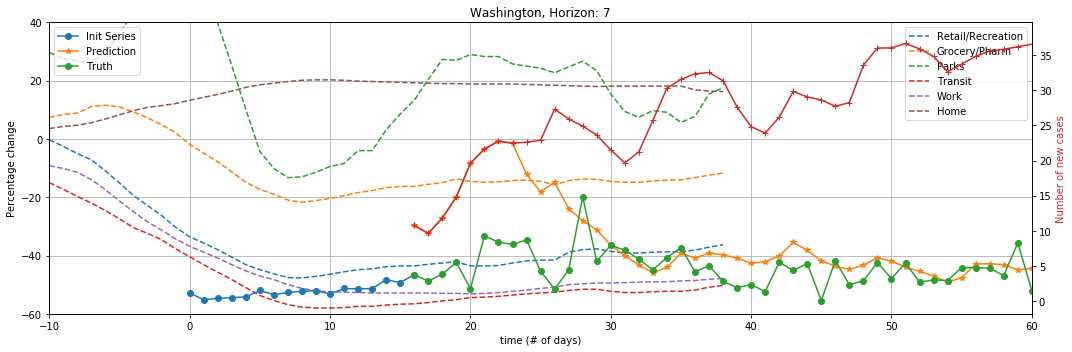

Wisconsin
53 (53,)
Wisconsin


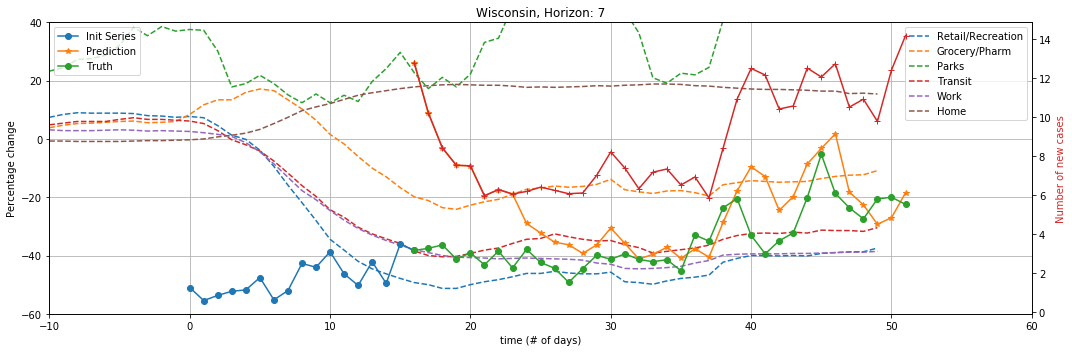

In [345]:
for g in range(len(Testing_States)):
    State_name = Testing_States[g]#'Pennsylvania'
    K=50
    Country ='United States'
    filter_size = 7 # days
    days_rnge = 0
    mobility = -50

    T_X,T_Y = getStateData(State_name)

    df_US =  df_loc[(df_loc["country_region"]== Country) & (df_loc["sub_region_2"].isna()==True) &(df_loc["sub_region_1"]==State_name)]
    d = Start_dte - np.timedelta64(10,'D')
    Start_dte,cases1,x_cases1 = getXY(State_name,K,True)
    # cases = moving_average(filter_size,cases1)
    cases=cases1
    x_cases = np.arange(0,len(cases))
    print(len(cases),x_cases.shape)


    yold= df_US[df_US['date']>d][df_US.columns[5:]].values
    check = moving_average(filter_size,yold[:,0])
    y = np.zeros((check.shape[0],yold.shape[1]))
    for i in range(yold.shape[1]):
        y[:,i]= moving_average(filter_size,yold[:,i])
    x = np.arange(-10,len(y)-10)
    fig,ax1 = plt.subplots()
    ax1.grid()
    fig.set_figheight(5)
    fig.set_figwidth(15)
    ax1.set_xlabel('time (# of days)')
    ax1.set_ylabel('Percentage change')
    ax1.plot(x, y,linestyle='--')
    # ax1.plot(x,np.mean(y[:,[0,3,4]],axis=1),color='r',marker = '*',linewidth = 3)
    ax1.tick_params(axis='y')
    plt.ylim(-60,40)
    ax1.legend(['Retail/Recreation','Grocery/Pharm','Parks','Transit','Work','Home'])

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Number of new cases', color=color)  # we already handled the x-label with ax1
    # ax2.plot(x_cases, cases,marker = 'o',color = 'b')# , color=color
    # ax2.tick_params(axis='y', labelcolor=color)

    # State_name = Testing_States[i]
    # T_X[:,:,1:] =0
    prediction = model.predict(T_X[:,:,:])
    Start_dte,cases_comp,x_cases = getXY(State_name,K,True)
    # plt.figure()
    ax2.plot(cases_comp[0:Mobility_data_lag+prediction_horizon],marker = "o")
    ax2.plot(np.arange(prediction_horizon+Mobility_data_lag-1,-1+prediction_horizon+Mobility_data_lag+T_Y.shape[0]),prediction,marker = '*')
    ax2.plot(np.arange(prediction_horizon+Mobility_data_lag-1,-1+prediction_horizon+Mobility_data_lag+T_Y.shape[0]),T_Y[:,prediction_horizon-1],marker = 'o')
    p,c = get_predictionBased(State_name,mobility,days_rnge)
    ax2.plot(np.arange(prediction_horizon+Mobility_data_lag-1,-1+prediction_horizon+Mobility_data_lag+T_Y.shape[0]),p[prediction_horizon+Mobility_data_lag:+prediction_horizon+Mobility_data_lag+T_Y.shape[0]],marker = '+')

    plt.title(State_name+ ", Horizon: "+str(prediction_horizon))
    #     plt.xlabel("Time(Day)")
    #     plt.ylabel("New cases per million")
    ax2.legend(["Init Series","Prediction","Truth"],loc= 2)
    #     plt.show()



    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    # plt.legend(['New Cases'])
    # plt.title(State_name)
    # plt.ylim(0,np.max(cases))
    plt.xlim(-10,60)
    plt.show()


In [311]:
p.shape,c.shape

((56,), (55,))

In [ ]:
prd = list()
for i in range(T_X.shape[0]):
# i=1
    if(i==0):
        prediction = model.predict(T_X[i:i+1,:,:])
        vec[0:Mobility_data_lag-1] = T_X[i:i+1,1:Mobility_data_lag,0]
        vec[Mobility_data_lag-1] = prediction
        prd.append(prediction)
    else:

        T_X[i:i+1,:,0] = vec
        prediction = model.predict(T_X[i:i+1,:,:])
        vec[0:Mobility_data_lag-1] = T_X[i:i+1,1:Mobility_data_lag,0]
        vec[Mobility_data_lag-1] = prediction
        prd.append(prediction)

In [234]:
T_X.shape

(38, 10, 7)

In [235]:
T_Y.shape

(38, 7, 1)

In [248]:
i=0
T_X[i+prediction_horizon,9,0],T_Y[i,6]

(11.341975223703008, array([11.34197522]))